## Tutorial-04 Intro to Frenet Optimal Planner

**Step 1** 从文件中读取全局路径

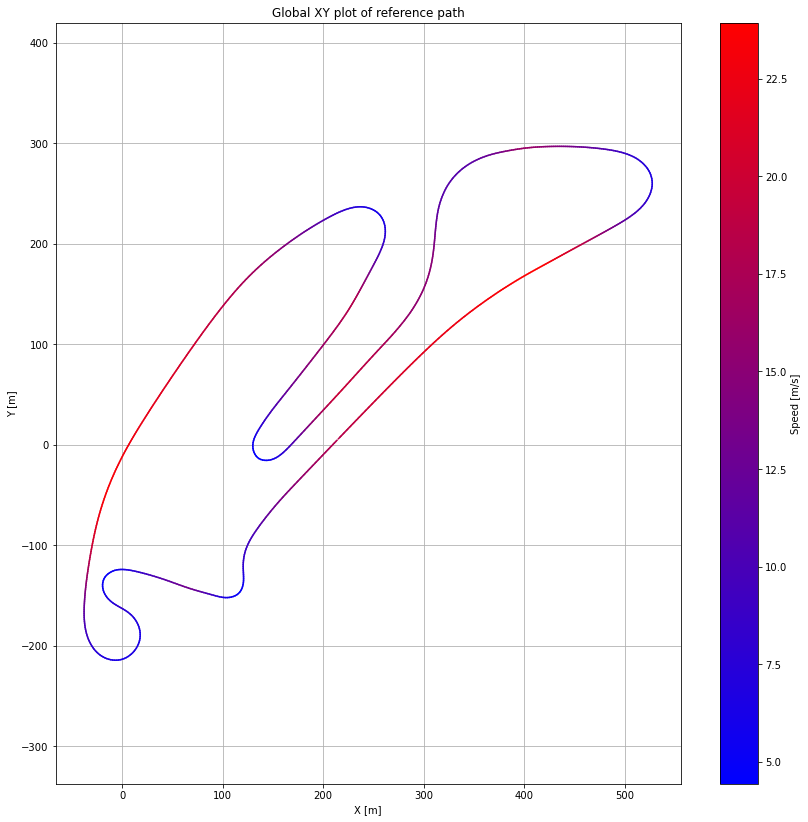

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

# 通过 numpy 的 genfromtxt 读取 csv 文件，并跳过第一行
trajectory_data = np.genfromtxt('./data/global_trajectory.csv', delimiter=';', skip_header=1)

# 为了避免行向量和列向量混淆导致的错误，尽可能使用 np.mat 而非 np.array 来进行数组操作
# 所以这里将读取的数据转换为了 np.mat 的格式
reference_trajectory = np.mat(trajectory_data)

# 将数组分割，方便后续操作
reference_s     = reference_trajectory[:, 0]             # [m]
reference_x     = reference_trajectory[:, 1]             # [m]
reference_y     = reference_trajectory[:, 2]             # [m]
reference_theta = reference_trajectory[:, 3] + math.pi/2 # [rad]
reference_v     = reference_trajectory[:, 5] * 0.44704   # [m/s]

# 使用 pyplot 的 Normalize 函数，将车速的最小值和最大值进行归一化处理
# 使其值位于 0-1 之间
norm = plt.Normalize(reference_v.min(), reference_v.max())

# 定义一个字典，用于描述色彩映射的过程。在这个字典中，键是颜色通道（'red', 'green', 'blue'），值是一个元组列表。
# 每个元组表示一个颜色通道在色彩映射中的变化过程，元组的第一个元素是颜色通道的位置（从 0 到 1），第二个和第三个元素是该位置的颜色值（也是从0到1）。
# 在此例中，我们定义了一个从蓝色过渡到红色的色彩映射。
cdict = {'red':   ((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)), 
         'green': ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0)), 
         'blue':  ((0.0, 1.0, 1.0), (1.0, 0.0, 0.0))} 

# 使用定义好的颜色字典创建线性分段色彩映射，映射的名称为 'Bl_Rd'，分段数为 256
c_m = LinearSegmentedColormap('Rd_Bl', cdict, 256)

# 创建一个新的图窗，并设置其尺寸为 8x8
fig, ax = plt.subplots(figsize=(14, 14))

# 遍历参考路径中的每个点，根据车速来选取颜色，并绘制对应的路径
for i in range(1, len(reference_x)):
    x_segment = np.array(reference_x[i-1:i+1]).ravel()
    y_segment = np.array(reference_y[i-1:i+1]).ravel()
    c_segment = c_m(norm(np.array(reference_v[i-1:i+1]).ravel()))
    ax.plot(x_segment, y_segment, color=c_segment[0])

# 在右边放置一个 colorbar
colorbar = cm.ScalarMappable(cmap=c_m, norm=norm)
colorbar.set_array([])
fig.colorbar(colorbar, label='Speed [m/s]')

plt.figure(1, figsize=(10, 10))
plt.grid(True)
plt.title('Global XY plot of reference path')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.axis('equal')

plt.show()

**Step 2** 根据全局路创建 Frenet 参考系

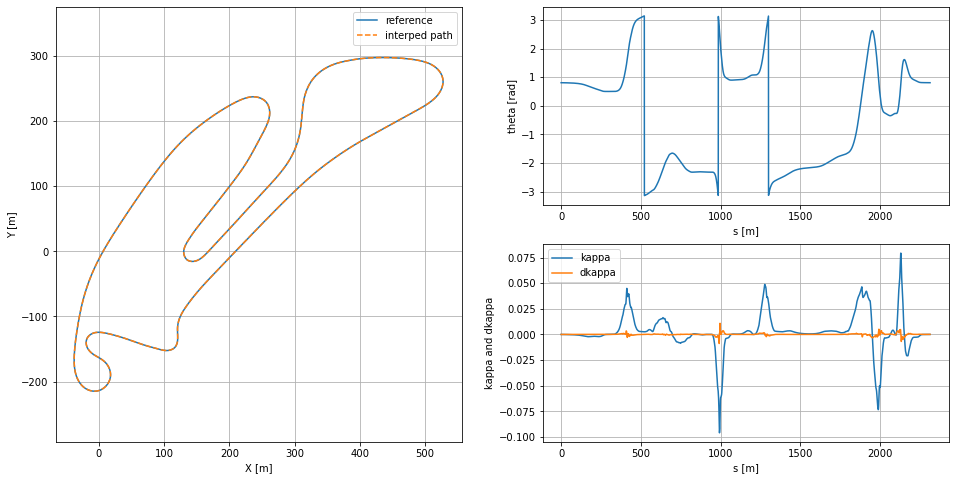

In [2]:
import copy
from scipy.interpolate import BSpline
import lib.utils as utils

'''
创建一个 ReferencePath 类来帮助 Local Planner 完成 frenet-cartesian 之间的坐标转换
'''
class ReferencePath:
    def __init__(
        self,
        waypoint_s: np.mat, # 参考路径点的累计弧长
        waypoint_x: np.mat, # 参考路径点的 x 坐标
        waypoint_y: np.mat, # 参考路径点的 y 坐标
        resolution: float
        ):       
        
        if len(waypoint_s) < 2:
            print('waypoints_s: ', waypoint_s)
            raise ValueError("Waypoint size less than 2")
        
        # 记录路径基本信息
        self.total_length_ = waypoint_s[-1, 0]
        
        # 使用三次样条曲线拟合
        spline_x = BSpline(np.ravel(waypoint_s), np.ravel(waypoint_x), 3)
        spline_y = BSpline(np.ravel(waypoint_s), np.ravel(waypoint_y), 3)
        
        # 初始化参考路径的分辨率
        self.sample_resolution_ = resolution
        self.interp_size_ = (np.ceil(self.total_length_ / self.sample_resolution_) + 1).astype(int)
        
        self.interp_s_ = np.linspace(0, self.total_length_, self.interp_size_)
        
        # 计算插值后的 x y theta kappa dkappa
        self.interp_x_      = np.mat(spline_x(self.interp_s_)).T
        self.interp_y_      = np.mat(spline_y(self.interp_s_)).T
        
        self.interp_theta_  = self.calculate_theta() 
        self.interp_kappa_  = self.calculate_kappa()
        self.interp_dkappa_ = self.calculate_dkappa()
    
    def calculate_theta(self):
        # 初始化航向角为空列表
        interp_theta = np.zeros((self.interp_size_, 1))
        
        # 如果路径点数量为 2，则无法使用中心差分
        if self.interp_size_ == 2:
            dy = self.interp_y_[1, 0] - self.interp_y_[1, 0]
            dx = self.interp_x_[1, 0] - self.interp_x_[0, 0]
            theta = np.arctan2(dy, dx)
            
            interp_theta[0, 0] = theta
            interp_theta[1, 0] = theta
            
            return np.mat(interp_theta)
        
        # 使用中心差分方法计算航向角        
        for i in range(1, self.interp_size_-1):
            dy = self.interp_y_[i + 1, 0] - self.interp_y_[i - 1, 0]
            dx = self.interp_x_[i + 1, 0] - self.interp_x_[i - 1, 0]    
            interp_theta[i, 0] = np.arctan2(dy, dx)
        
        # 补全两头的航向信息
        interp_theta[ 0, 0] = copy.deepcopy(interp_theta[ 1, 0])
        interp_theta[-1, 0] = copy.deepcopy(interp_theta[-2, 0])
        
        return np.mat(interp_theta)
    
    def calculate_kappa(self):
        # 初始化所有曲率为 0
        interp_kappa = np.zeros((self.interp_size_, 1))
        
        # 使用中心差分法计算曲率
        for i in range(1, self.interp_size_ - 1):
            dtheta = utils.normalize_angle(self.interp_theta_[i + 1, 0] - self.interp_theta_[i - 1, 0])
            ds = self.interp_s_[i + 1] - self.interp_s_[i - 1]
            interp_kappa[i, 0] = dtheta / ds
        
        # 补全两头的航向信息    
        interp_kappa[ 0, 0] = copy.deepcopy(interp_kappa[ 1, 0])
        interp_kappa[-1, 0] = copy.deepcopy(interp_kappa[-2, 0])

        return np.mat(interp_kappa)

    def calculate_dkappa(self):
        # 初始化曲率变化率为 0
        interp_dkappa = np.zeros((self.interp_size_, 1))
        
        # 使用中心差分法计算曲率
        for i in range(1, self.interp_size_ - 1):
            dkappa = self.interp_kappa_[i + 1, 0] - self.interp_kappa_[i - 1, 0]
            ds = self.interp_s_[i + 1] - self.interp_s_[i - 1]
            interp_dkappa[i, 0] = dkappa / ds

        # 补全两头的曲率变化率信息
        interp_dkappa[0, 0]  = copy.deepcopy(interp_dkappa[1, 0])
        interp_dkappa[-1, 0] = copy.deepcopy(interp_dkappa[-2, 0])

        return np.mat(interp_dkappa)
    
ref_path = ReferencePath(reference_s, reference_x, reference_y, 0.5)

plt.figure(2, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(reference_x, reference_y, label='reference')
plt.plot(ref_path.interp_x_, ref_path.interp_y_, linestyle='dashed', label='interped path')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.axis('equal')
plt.grid(True)
plt.box(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(ref_path.interp_s_, ref_path.interp_theta_)
plt.xlabel('s [m]')
plt.ylabel('theta [rad]')
plt.axis('tight')
plt.grid(True)
plt.box(True)

plt.subplot(2, 2, 4)
plt.plot(ref_path.interp_s_, ref_path.interp_kappa_, label='kappa')
plt.plot(ref_path.interp_s_, ref_path.interp_dkappa_, label='dkappa')
plt.xlabel('s [m]')
plt.ylabel('kappa and dkappa')
plt.axis('tight')
plt.grid(True)
plt.box(True)
plt.legend()

plt.show()


**Step 3** 测试 Frenet 坐标系下的五次多项式横 / 纵向采样

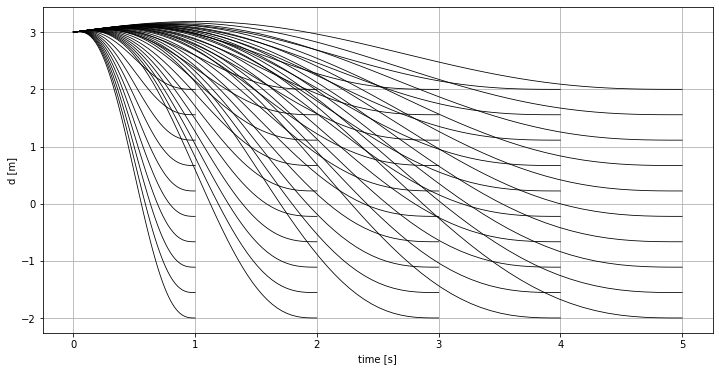

In [3]:
import lib.polynomial as poly

# 测试五次多项式采样
# 初始的横向状态
initial_d      = 3   # 初始的横向位移
initial_d_dot  = 0.3 # 初始的横向速度
initial_d_ddot = 0   # 初始的横向加速度
initial_time   = 0   # 采样的起始时间

# 终止的侧向状态
terminal_d_list = np.linspace(-2, 2, 10) # 采样的目标侧向位移
terminal_d_dot  = 0                     # 采样的终止侧向速度
terminal_d_ddot = 0                     # 采样点终止侧向加速度
terminal_time_list   = [1, 2, 3, 4, 5]  # 采样的终止时间

# 采样点的个数
sample_num = 50

plt.figure(3, figsize=(12, 6))
for terminal_time in terminal_time_list:
    sample_time = np.linspace(initial_time, terminal_time, sample_num)
    
    for terminal_d in terminal_d_list:
        lateral_trajectory = poly.QuinticPolynomial(
            initial_d , initial_d_dot , initial_d_ddot , 
            terminal_d, terminal_d_dot, terminal_d_ddot, 
            sample_time
        )
        
        plt.plot(sample_time, np.ravel(lateral_trajectory.p_), color='black', linewidth=0.8)

plt.grid(True)
plt.axis('tight')
plt.xlabel('time [s]')
plt.ylabel('d [m]')
plt.show()

**Step 4** 测试 Frenet 坐标系下四次多项式的纵向采样

Text(0, 0.5, 's_dot [m/s]')

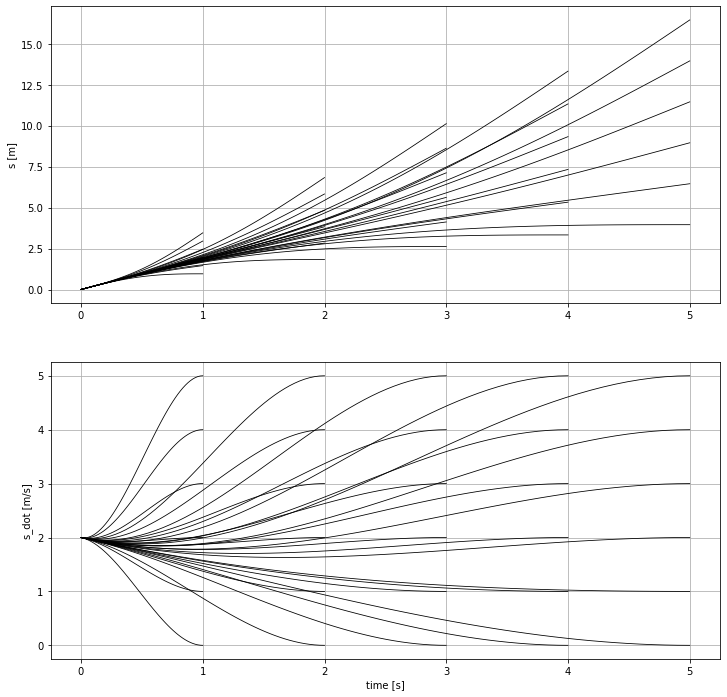

In [4]:
# 测试五次多项式采样
# 初始的横向状态
initial_s      =  0   # 起点累计弧长
initial_s_dot  =  2.0 # 初始纵向速度
initial_s_ddot = -0.5 # 初始的纵向加速度
initial_time   =  0   # 采样的起始时间

# 终止的侧向状态
terminal_s_dot_list = np.linspace(0, 5, 6) # 采样的目标车速
terminal_s_ddot  = 0                       # 采样的目标加速度
terminal_time_list   = [1, 2, 3, 4, 5]     # 采样的终止时间

# 采样点的个数
sample_num = 50

plt.figure(3, figsize=(12, 12))
ax_s     = plt.subplot(2, 1, 1)
ax_s_dot = plt.subplot(2, 1, 2)

for terminal_time in terminal_time_list:
    sample_time = np.linspace(initial_time, terminal_time, sample_num)
    
    for terminal_s_dot in terminal_s_dot_list:
        longitudinal_trajectory = poly.QuarticPolinomial(
            initial_s     , initial_s_dot  , initial_s_ddot, 
            terminal_s_dot, terminal_s_ddot, sample_time
        )
        
        ax_s.plot(sample_time, np.ravel(longitudinal_trajectory.p_), color='black', linewidth=0.8)
        ax_s_dot.plot(sample_time, np.ravel(longitudinal_trajectory.p_dot_), color='black', linewidth=0.8)
        
#筛选最优采样轨迹
#轨迹末端继续采样
ax_s.grid(True)
ax_s_dot.grid(True)
ax_s.set_ylabel('s [m]')
ax_s_dot.set_xlabel('time [s]')
ax_s_dot.set_ylabel('s_dot [m/s]')

**Step 6** 创建 Frenet Optimal Planner 局部规划器

Text(0, 0.5, 'Y [m]')

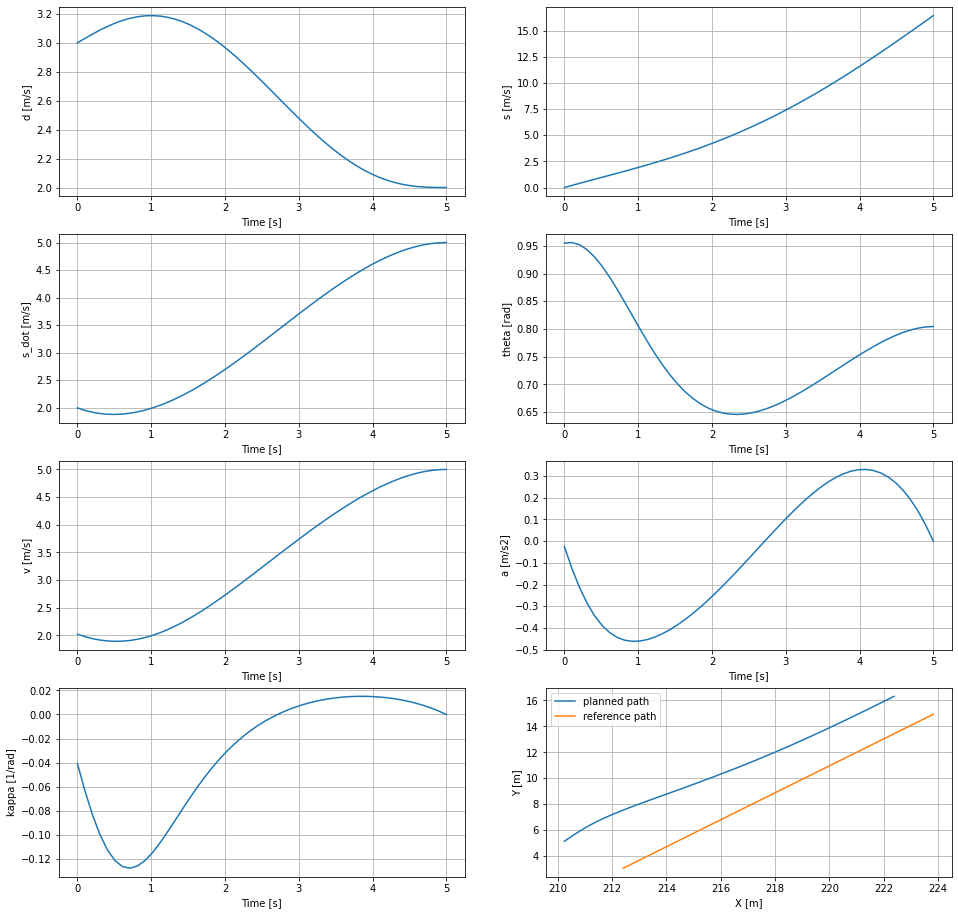

In [5]:
import lib.utils

class Trajectory:
    def __init__(
        self,
        longitudinal_curve: poly.QuarticPolinomial,
        lateral_curve: poly.QuinticPolynomial,
        t_array: np.array,
        reference_path: ReferencePath
        ):
        
        self.sample_time_ = t_array

        self.s_      = longitudinal_curve.p_
        self.s_dot_  = longitudinal_curve.p_dot_
        self.s_ddot_ = longitudinal_curve.p_ddot_
        self.s_ddot_ = longitudinal_curve.p_dddot_

        self.d_       = lateral_curve.p_
        self.d_dot_   = lateral_curve.p_dot_
        self.d_ddot_  = lateral_curve.p_ddot_
        self.d_dddot_ = lateral_curve.p_dddot_

        # 计算横 / 纵向轨迹的 Jerk 代价
        self.lateral_jerk_      = np.trapz(np.ravel(self.d_dddot_) ** 2, self.sample_time_)
        self.longitudinal_jerk_ = np.trapz(np.ravel(self.s_ddot_)  ** 2, self.sample_time_)
        
        self.frenet_to_cartesian(reference_path)
    
    def frenet_to_cartesian(self, reference_path: ReferencePath):
        x_ref      = np.interp(self.s_, np.ravel(reference_path.interp_s_), np.ravel(reference_path.interp_x_))
        y_ref      = np.interp(self.s_, np.ravel(reference_path.interp_s_), np.ravel(reference_path.interp_y_))
        theta_ref  = np.interp(self.s_, np.ravel(reference_path.interp_s_), np.ravel(reference_path.interp_theta_))
        kappa_ref  = np.interp(self.s_, np.ravel(reference_path.interp_s_), np.ravel(reference_path.interp_kappa_))
        dkappa_ref = np.interp(self.s_, np.ravel(reference_path.interp_s_), np.ravel(reference_path.interp_dkappa_))
        
        self.x_ref_      = np.mat(x_ref)
        self.y_ref_      = np.mat(y_ref)
        self.theta_ref_  = np.mat(theta_ref)
        self.kappa_ref_  = np.mat(kappa_ref)
        self.dkappa_ref_ = np.mat(dkappa_ref)
        
        cartesian_x = np.ravel(self.x_ref_) - np.ravel(self.d_) * np.sin(np.ravel(self.theta_ref_))
        cartesian_y = np.ravel(self.y_ref_) + np.ravel(self.d_) * np.cos(np.ravel(self.theta_ref_))
        
        self.x_ = np.mat(cartesian_x).T
        self.y_ = np.mat(cartesian_y).T
    
        # 计算 d(s) 的一阶导
        d_prime = np.ravel(self.d_dot_) / np.ravel(self.s_dot_)

        # 计算 d(s) 的二阶导       
        d_pprime = (np.ravel(self.d_ddot_) - d_prime * np.ravel(self.s_ddot_)) / (np.ravel(self.s_dot_) ** 2)

        # 计算航向角增量
        delta_theta = np.arctan2(d_prime, (1 - np.ravel(kappa_ref) * np.ravel(self.d_)))
        
        # 计算航向角
        theta = np.ravel(theta_ref) + delta_theta
        self.theta_ = np.mat(theta).T
        
        # 计算车速
        v = np.ravel(self.s_dot_) * (1 - np.ravel(kappa_ref) * np.ravel(self.d_)) / np.cos(delta_theta)
        self.v_ = np.mat(v).T
        
        # 计算曲率
        kappa = (((d_pprime + (np.ravel(dkappa_ref) * np.ravel(self.d_) + np.ravel(kappa_ref) * d_prime) * np.tan(delta_theta))
            * (np.cos(delta_theta) ** 2) / (1 - np.ravel(kappa_ref) * np.ravel(self.d_))
            + np.ravel(kappa_ref)
        ) * np.cos(delta_theta) / (1 - np.ravel(kappa_ref) * np.ravel(self.d_)))    
        
        self.kappa_ = np.mat(kappa).T
        
        # 计算加速度
        a = np.ravel(self.d_ddot_) * (1 - np.ravel(kappa_ref) * np.ravel(self.d_)) / np.cos(delta_theta) + (
            np.ravel(self.s_dot_) ** 2
        ) / np.cos(delta_theta) * (
            (1 - np.ravel(kappa_ref) * np.ravel(self.d_))
            * np.tan(delta_theta)
            * (
                np.ravel(self.kappa_) * (1 - np.ravel(kappa_ref) * np.ravel(self.d_)) / np.cos(delta_theta)
                - np.ravel(kappa_ref)
            )
            - (np.ravel(dkappa_ref) * np.ravel(self.d_) + np.ravel(dkappa_ref) * d_prime)
        )
        
        self.a_ = np.mat(a).T
        return
    
cartesian_trajectory = Trajectory(longitudinal_trajectory, lateral_trajectory, sample_time, ref_path)
area = 30

plt.figure(4, figsize=(16, 16))
plt.subplot(4, 2, 1)
plt.plot(sample_time, np.ravel(lateral_trajectory.p_))
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('d [m/s]')

plt.subplot(4, 2, 2)
plt.plot(sample_time, np.ravel(longitudinal_trajectory.p_))
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('s [m/s]')

plt.subplot(4, 2, 3)
plt.plot(sample_time, np.ravel(longitudinal_trajectory.p_dot_))
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('s_dot [m/s]')

plt.subplot(4, 2, 4)
plt.plot(sample_time, cartesian_trajectory.theta_ )
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('theta [rad]')

plt.subplot(4, 2, 5)
plt.plot(sample_time, cartesian_trajectory.v_)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('v [m/s]')

plt.subplot(4, 2, 6)
plt.plot(sample_time, cartesian_trajectory.a_)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('a [m/s2]')

plt.subplot(4, 2, 7)
plt.plot(sample_time, cartesian_trajectory.kappa_)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('kappa [1/rad]')

plt.subplot(4, 2, 8)
plt.plot(cartesian_trajectory.x_, cartesian_trajectory.y_, label='planned path')
plt.plot(cartesian_trajectory.x_ref_, cartesian_trajectory.y_ref_, label='reference path')
plt.grid(True)
plt.legend()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

**Step 7** 建立一个碰撞检测器用于筛选发生碰撞的路径

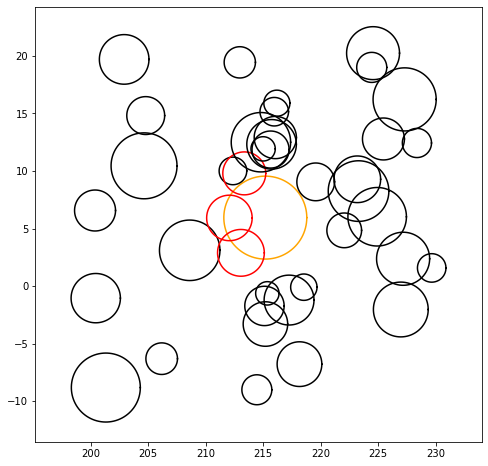

In [6]:
import lib.data_struct as struct

class VehicleGeometry:
    # rl ------------- fl
    #    |           |
    #    |           |
    # rr ------------ fr
    def __init__(self, l, w):
        self.l_ = l
        self.w_ = w
        
        self.corner_fl = [ l/2,  w/2]
        self.corner_fr = [ l/2, -w/2]
        self.corner_rl = [-l/2,  w/2]
        self.corner_rr = [-l/2, -w/2]
        
        self.radius_ = math.sqrt(l**2 + w**2)

    def check_collision_free(self, ego_x, ego_y, obstacle_state: struct.StaticObstacle):
        obs_x = obstacle_state.pose_.x_
        obs_y = obstacle_state.pose_.y_
        
        dist  = utils.distance(ego_x, ego_y, obs_x, obs_y)
        
        # 如果车和障碍物之间的距离大于碰撞半径，则说明无碰撞
        if dist > self.radius_ + obstacle_state.radius_:
            return True
        else:
            return False

def plot_circle(center_x, center_y, radius, circle_color):
    theta = np.linspace(0, 2*math.pi, 100)
    x = radius * np.cos(theta) + center_x
    y = radius * np.sin(theta) + center_y
    
    plt.plot(x, y, color=circle_color)
    
    return
    
# 初始化车辆位置和碰撞检测器
initial_pose = struct.Transform(reference_x[0, 0], 
                                reference_y[0, 0], 
                                reference_theta[0, 0])

initial_state = struct.State(initial_pose, v=0, a=0)

vehicle_geometry = VehicleGeometry(l=3, w=2)

# 生成测试场景
obs_num = 40
obs_x_list      = initial_pose.x_ + np.random.uniform(-15, 15, obs_num)
obs_y_list      = initial_pose.y_ + np.random.uniform(-15, 15, obs_num)
obs_radius_list = np.random.uniform(1, 3, obs_num)

# 创建一个新的图形和坐标轴
plt.figure(5, figsize=(8, 8))

plot_circle(initial_pose.x_, 
            initial_pose.y_, 
            vehicle_geometry.radius_, 
            'orange')

# 以 obs_x, obs_y 为圆心，obs radius 为半径画黑色的圆形
for x, y, radius in zip(obs_x_list, obs_y_list, obs_radius_list):
    obs_pose = struct.Transform(x, y, 0)
    obs_state = struct.StaticObstacle(obs_pose, radius)
    
    if vehicle_geometry.check_collision_free(initial_state.pose_.x_, initial_state.pose_.y_, obs_state):
        plot_circle(x, y, radius, 'black')
    else:
        plot_circle(x, y, radius, 'red')
    
    

plt.axis('equal')    
plt.show()  # 显示图形

**Step 8** 集成上述功能，实现完整的局部轨迹规划

c:\ProgramData\anaconda3\envs\kyxz_test\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
c:\ProgramData\anaconda3\envs\kyxz_test\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in subtract
c:\ProgramData\anaconda3\envs\kyxz_test\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
c:\ProgramData\anaconda3\envs\kyxz_test\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in add


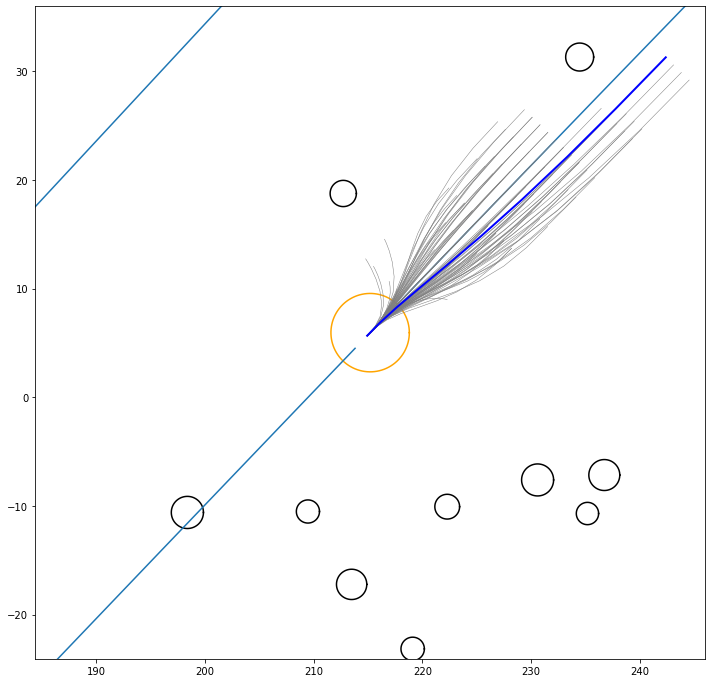

In [7]:
class FrenetOptimalPlanner:
    def __init__(self, reference_path: ReferencePath):
        self.min_terminal_t_ = 2  # 最小采样终止时间
        self.max_terminal_t_ = 3  # 最大采样终止时间
        self.num_terminal_t_ = 3  # 采样终止时间的个数
        self.num_sample_t_   = 10 # 采样时间离散的数量
        
        self.min_terminal_v_ = 0  # 最小减速到 0
        self.max_terminal_v_ = 20 # 最快加速到 50 m/s
        self.num_terminal_v_ = 5  # 速度采样的个数
        
        self.min_terminal_d_ = -5 # 左侧最大偏移量
        self.max_terminal_d_ =  5 # 右侧最大偏移量
        self.num_terminal_d_ = 11 # 横向采样个数 
        
        self.lateral_jerk_coeff_    = 1   # 侧向加速度变化代价
        self.lateral_time_coeff_    = 0.1 # 换道时间代价
        self.lateral_deviate_coeff_ = 1  # 与参考线偏差代价
        
        self.longitudinal_jerk_coeff_ = 1     # 纵向加速度变化代价
        self.longitudinal_time_coeff_ = 0.1   # 加/减速时间代价
        self.longitudinal_deviate_coeff_ = 5  # 与目标车速偏差代价
        
        self.lateral_cost_coeff_ = 1          # 横向代价
        self.longitudinal_cost_coeff_ = 5     # 纵向代价
        
        self.target_v_ = self.max_terminal_v_ # 目标车速
        
        self.kappa_limit_ = 0.1 # 曲率限制
        self.a_limit_     = 5   # 加速度限制
        self.v_limit_     = 30  # 速度限制
        
        self.reference_path_ = reference_path
        
    def generate_trajectory_sample(self, frenet_state: struct.FrenetState):
        longitudinal_sample_list  = []
        lateral_sample_list       = []
        cartesian_trajectory_list = []
        
        terminal_s_ddot = 0
        terminal_d_dot  = 0
        terminal_d_ddot = 0
        
        # 生成采样轨迹
        for terminal_t in np.linspace(self.min_terminal_t_, 
                                      self.max_terminal_t_, 
                                      self.num_terminal_t_):
            sample_time = np.linspace(0, terminal_t, self.num_sample_t_)
            
            for terminal_s_dot in np.linspace(self.min_terminal_v_, 
                                              self.max_terminal_v_, 
                                              self.num_terminal_v_):
                longitudinal_sample = poly.QuarticPolinomial(
                    frenet_state.s_, frenet_state.s_dot_, frenet_state.s_ddot_,
                    terminal_s_dot , terminal_s_ddot    , sample_time)
                
                longitudinal_sample_list.append(longitudinal_sample)
                
                for terminal_d in np.linspace(self.min_terminal_d_, 
                                              self.max_terminal_d_, 
                                              self.num_terminal_d_):    
                    lateral_sample = poly.QuinticPolynomial(
                        frenet_state.d_, frenet_state.d_dot_, frenet_state.d_ddot_, 
                        terminal_d     , terminal_d_dot     , terminal_d_ddot, 
                        sample_time
                    )
                    
                    lateral_sample_list.append(lateral_sample)
                    
                    # 将横、纵向采样结果耦合，得到 Cartesian 坐标系下的轨迹
                    cartesian_trajectory = Trajectory(longitudinal_sample, 
                                                      lateral_sample, 
                                                      sample_time, 
                                                      self.reference_path_)
                    
                    cartesian_trajectory_list.append(cartesian_trajectory)
                            
        return cartesian_trajectory_list
                        
    def choose_optimal_trajectory(self, cartesian_trajectory_list: list, vehicle_geometry: VehicleGeometry, obs_list: list):
        valid_trajectory = []
        trajectory_cost_list = []
        
        for cartesian_trajectory in cartesian_trajectory_list:
            max_kappa = np.amax(cartesian_trajectory.kappa_)
            max_a = np.amax(cartesian_trajectory.a_)
            max_v = np.amax(cartesian_trajectory.v_) 
            min_v = np.amin(cartesian_trajectory.v_)
            
            # 检查硬约束
            if abs(max_kappa) > self.kappa_limit_ or max_a > self.a_limit_ or max_v > self.v_limit_ or min_v < 0:
                continue          
            
            # 检查碰撞约束
            collision_flag = 0
            for i in range(len(obs_list)):
                obs = obs_list[i]
                for j in range(len(cartesian_trajectory.s_)):
                    if not vehicle_geometry.check_collision_free(cartesian_trajectory.x_[j], 
                                                                 cartesian_trajectory.y_[j],
                                                                 obs):
                        collision_flag = 1
            
            if collision_flag:
                continue
                
            lateral_cost = (
                self.lateral_jerk_coeff_    * cartesian_trajectory.lateral_jerk_ + 
                self.lateral_time_coeff_    * cartesian_trajectory.sample_time_[-1] +
                self.lateral_deviate_coeff_ * cartesian_trajectory.d_[-1, 0] ** 2
                )
            
            longitudinal_cost = (
                self.longitudinal_jerk_coeff_ * cartesian_trajectory.longitudinal_jerk_ + 
                self.longitudinal_time_coeff_ * cartesian_trajectory.sample_time_[-1] + 
                self.longitudinal_deviate_coeff_  * (cartesian_trajectory.v_[-1, 0] - self.target_v_)**2
            )
            
            total_cost = (self.lateral_cost_coeff_ * lateral_cost 
                            + self.longitudinal_cost_coeff_ * longitudinal_cost)
            
            
            if math.isnan(total_cost):
                continue
            
            valid_trajectory.append(cartesian_trajectory)
            trajectory_cost_list.append(total_cost)
    
        if valid_trajectory:
            optimal_trajectory_cost = min(trajectory_cost_list)
            optimal_trajectory_index = trajectory_cost_list.index(optimal_trajectory_cost)
            optimal_trajectory = valid_trajectory[optimal_trajectory_index]
        else:
            optimal_trajectory = math.nan
        
        return optimal_trajectory, valid_trajectory
    
    def update_planning(self, frenet_state: struct.FrenetState, vehicle_geometry: VehicleGeometry, obs_list: list):
        trajectory_list = self.generate_trajectory_sample(frenet_state)
        optimal_trajectory, valid_trajectory = planner.choose_optimal_trajectory(trajectory_list, vehicle_geometry, obs_list)
        
        return optimal_trajectory, valid_trajectory

plt.figure(6, figsize=(12, 12))
plt.axis('equal')
            
# 初始化车辆位置和碰撞检测器
initial_pose = struct.Transform(reference_x[0, 0], 
                                reference_y[0, 0], 
                                reference_theta[0, 0])

initial_state = struct.State(initial_pose, v=0, a=0)
vehicle_geometry = VehicleGeometry(l=3, w=2)

plot_circle(initial_pose.x_, 
            initial_pose.y_, 
            vehicle_geometry.radius_, 
            'orange')

# 生成测试场景
obs_num = 10
obs_x_list      = initial_pose.x_ + np.random.uniform(-30, 30, obs_num)
obs_y_list      = initial_pose.y_ + np.random.uniform(-30, 30, obs_num)
obs_radius_list = np.random.uniform(1, 1.5, obs_num)

obs_list = []
for x, y, radius in zip(obs_x_list, obs_y_list, obs_radius_list):
    obs_pose = struct.Transform(x, y, 0)
    obs = struct.StaticObstacle(obs_pose, radius)
    obs_list.append(obs)
    
    plot_circle(x, y, radius, 'black')

plt.plot(reference_x, reference_y)

area = 30
plt.xlim(initial_pose.x_ - area, initial_pose.x_ + area)
plt.ylim(initial_pose.y_ - area, initial_pose.y_ + area)

initial_frenet_state = struct.FrenetState(s=vehicle_geometry.radius_, 
                                          s_dot=5, s_ddot=0, 
                                          d=0, d_dot=0, d_ddot=0)

planner = FrenetOptimalPlanner(ref_path)
optimal_trajectory, valid_trajectory = planner.update_planning(initial_frenet_state, 
                                                               vehicle_geometry, 
                                                               obs_list)

if valid_trajectory:
    for trajectory in valid_trajectory:
        plt.plot(trajectory.x_, trajectory.y_, color='gray', linewidth=0.5)
        
    plt.plot(optimal_trajectory.x_, optimal_trajectory.y_, color='blue', linewidth=2)
    plt.show()
else:
    print("No Available Path!")

In [8]:
# TODO:
# 1. 在假设车辆跟踪误差为 0 的情况下测试局部规划的性能
# 2. 加入简单的车辆运动学模型，stanley 横向控制以及 PID 纵向控制，进行集成测试
# 3. 加入全局规划的内容，完成全部流程
# 4. 接入仿真平台进行仿真
# 5. 使用 Numba 加速涉及到循环的计算